[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...


✅ Best Parameters: {'clf__alpha': 0.1, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}

Confusion Matrix:
 [[1205    2]
 [  21  165]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.99      0.89      0.93       186

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393

Accuracy: 0.9834888729361091


C:\Users\Dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


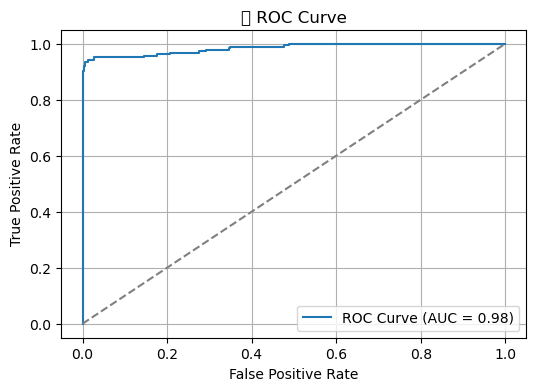


Test: 'Congratulations! You've won a free iPhone'
Prediction: Spam


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib

nltk.download('stopwords')
nltk.download('wordnet')

# Load Dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_table(url, header=None, names=['label', 'message'])

# Text Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

df['clean_message'] = df['message'].apply(preprocess)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Train/Test Split
X = df['clean_message']
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline and Grid Search
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'tfidf__max_df': [0.7, 0.85],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)

# Predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('📊 Confusion Matrix')
plt.show()

# Evaluation Report
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Extra: Count of predictions
print(f"\n🔢 Predicted Ham count: {(y_pred == 0).sum()}")
print(f"🔢 Predicted Spam count: {(y_pred == 1).sum()}")

# ROC Curve
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🚀 ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Save model
joblib.dump(best_model, 'spam_detector_advanced_model.pkl')

# Predict single message
def predict_message(msg):
    clean_msg = preprocess(msg)
    prediction = best_model.predict([clean_msg])[0]
    confidence = best_model.predict_proba([clean_msg])[0][prediction]
    label = "📩 Ham" if prediction == 0 else "📢 Spam"
    return f"{label} ({confidence*100:.2f}% confidence)"

# Test Prediction
test_msg = "Congratulations! You've won a free iPhone"
print(f"\n🧪 Test Message: \"{test_msg}\"")
print("🔍 Prediction:", predict_message(test_msg))
